In [62]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (InputLayer, Conv2D, MaxPooling2D, 
                                    Dropout, BatchNormalization, Dense,
                                    Flatten)


import pandas as pd
from tensorflow.data import Dataset
from tqdm import tqdm
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

### Model Building

CNN Experiment 1
- The paper, Enhancing Early Detection of Diabetic Retinopathy, introduced a CNN model which *outperformed* the complex architectures like ResNet-50, VGG-16 etc.
- It is a 5-layer architecture
- The First convolutional layer has 8 filters, of 3 x 3 kernel.
- Incrementally increased the size to 128 channels with 5 x 5 kernel.
- ReLU activation was used.
- MaxPooling is applied, to reduce dimensions. It outputs feature maps that has the most activations.
- MaxPooling at this stage reduces the width and height from 224 to 112.
- Then Another Convolutional block is used to get 128 channels.
- Then Again Max Pooling is applied and reduce size of image to 56 x 56.
- Then a Dropout layer with 0.5 neurons deactivated, for avoiding overfit.
- Then the tensor is batch Normalized.
- Flatten Layer
- 2 Dense Layer, with last layer as the classification layer with softmax activation.
- **Expected Baseline accuracy : 95%**

 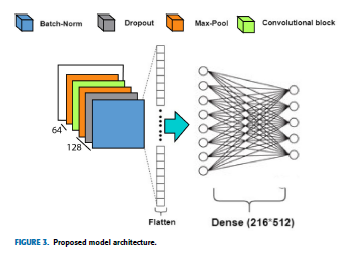

In [35]:
model_cnn_1 = Sequential([
    InputLayer(shape=(224,224,3)),
    # Conv 1
    Conv2D(filters=8,kernel_size=3,activation="relu",padding="same"),
    MaxPooling2D(strides=2), 
    # Conv 2
    Conv2D(filters=16,kernel_size=3,activation="relu",padding="same"),
    MaxPooling2D(),
    # Conv 3
    Conv2D(filters=32,kernel_size=5,activation="relu",padding="same"),
    MaxPooling2D(),
    # Conv 4
    Conv2D(filters=64,kernel_size=5,activation="relu",padding="same"),
    MaxPooling2D(),
    # Conv 5 
    Conv2D(filters=128,kernel_size=5,activation="relu",padding="same"),
    MaxPooling2D(),
    Dropout(0.5),
    BatchNormalization(),
    Flatten(),
    Dense(512,activation="relu"),
    Dense(5, activation="softmax")
])
model_cnn_1.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_38 (Conv2D)              │ (None, 224, 224, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 112, 112, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 112, 112, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 56, 56, 32)     │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 28, 28, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 14, 14, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,485,269 (13.30 MB)

 Trainable params: 3,485,013 (13.29 MB)

 Non-trainable params: 256 (1.00 KB)

In [64]:
# paths for aptos...
aptos_path = "../data/aptos_2019_blindness_detection/balanced_resized/"
aptos_train_path = aptos_path + "images"
aptos_train_csv_path = aptos_path + "labels.csv"
train_csv = pd.read_csv(aptos_train_csv_path)
img_type = ".png"
# Loading the main dataset and shuffing data
def get_example(row):
    file_name = "/" + row["img_name"]
    file_path = aptos_train_path + file_name + img_type
    raw_file = tf.io.read_file(file_path)
    image_file = tf.image.decode_png(raw_file, channels=3)
    image_file = tf.image.resize(image_file, [224, 224])  # Resize images
    one_hot_output = tf.one_hot(row["class"], depth=5)
    return image_file, one_hot_output
    
dr_dataset = Dataset.from_tensor_slices(dict(train_csv)).map(get_example).shuffle(500,seed=573)
# Splitting the resnet Model
batch_size = 8

train_size = int(0.8 * len(dr_dataset))
val_size = int(0.2 * len(dr_dataset))
test_size = len(dr_dataset) - train_size - val_size

train_dataset = dr_dataset.take(train_size)
val_dataset =  dr_dataset.skip(train_size).take(val_size)
test_dataset =  dr_dataset.skip(train_size + val_size).take(test_size)

train_dataset = train_dataset.batch(batch_size)
val_dataset_pred = val_dataset.batch(1)
val_dataset = val_dataset.batch(8)

model_cnn_1.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["categorical_accuracy","recall","precision"]
)

history = model_cnn_1.fit(
    train_dataset,
    epochs = 20,
    validation_data=val_dataset
)

Epoch 1/20
1852/1852 ━━━━━━━━━━━━━━━━━━━━ 44s 21ms/step - categorical_accuracy: 0.8596 - loss: 0.3869 - precision: 0.8814 - recall: 0.8367 - val_categorical_accuracy: 0.6064 - val_loss: 1.3209 - val_precision: 0.6481 - val_recall: 0.5656
Epoch 2/20
1852/1852 ━━━━━━━━━━━━━━━━━━━━ 36s 19ms/step - categorical_accuracy: 0.8703 - loss: 0.3408 - precision: 0.8935 - recall: 0.8481 - val_categorical_accuracy: 0.6053 - val_loss: 1.3475 - val_precision: 0.6465 - val_recall: 0.5675
Epoch 3/20
1852/1852 ━━━━━━━━━━━━━━━━━━━━ 36s 19ms/step - categorical_accuracy: 0.8713 - loss: 0.3473 - precision: 0.8958 - recall: 0.8521 - val_categorical_accuracy: 0.6180 - val_loss: 1.4712 - val_precision: 0.6473 - val_recall: 0.5905
Epoch 4/20
1852/1852 ━━━━━━━━━━━━━━━━━━━━ 36s 19ms/step - categorical_accuracy: 0.8846 - loss: 0.3145 - precision: 0.9038 - recall: 0.8646 - val_categorical_accuracy: 0.5956 - val_loss: 1.6311 - val_precision: 0.6208 - val_recall: 0.5719
Epoch 5/20
1852/1852 ━━━━━━━━━━━━━━━━━━━━ 37s 20

In [66]:
# Confusion matrix for all of the validation data with resnet50 model

# find the Confusion Matrix
ground_truths = []
predictions = []
for row in tqdm(val_dataset_pred):
    image = row[0].numpy()
    image_class = np.argmax(row[1].numpy())
    current_prediction = np.argmax(model_cnn_1.predict(image,verbose=0))
    ground_truths.append(image_class)
    predictions.append(current_prediction)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3702/3702 [03:44<00:00, 16.50it/s]


# First 20 epochs

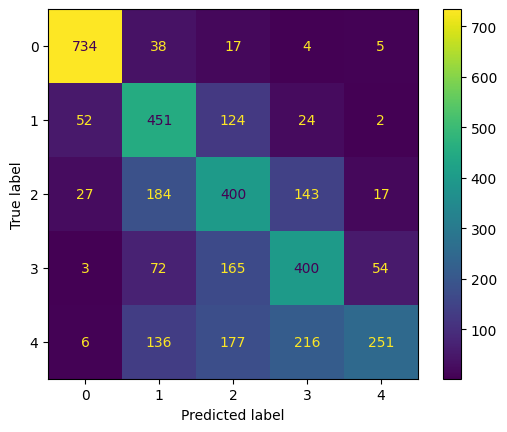

In [60]:
conf_matrix = confusion_matrix(ground_truths,predictions)

# Plot matrix
conf_fig = ConfusionMatrixDisplay(conf_matrix)
conf_fig.plot()

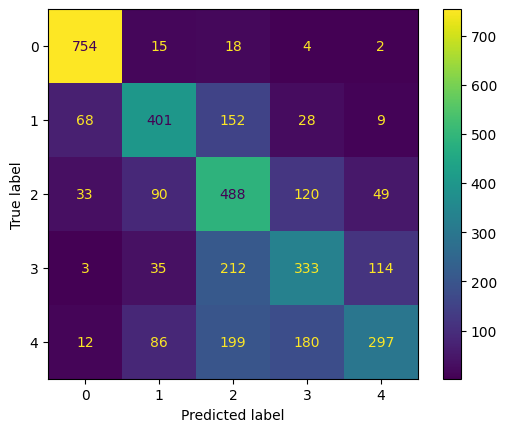

In [67]:
conf_matrix = confusion_matrix(ground_truths,predictions)

# Plot matrix
conf_fig = ConfusionMatrixDisplay(conf_matrix)
conf_fig.plot()

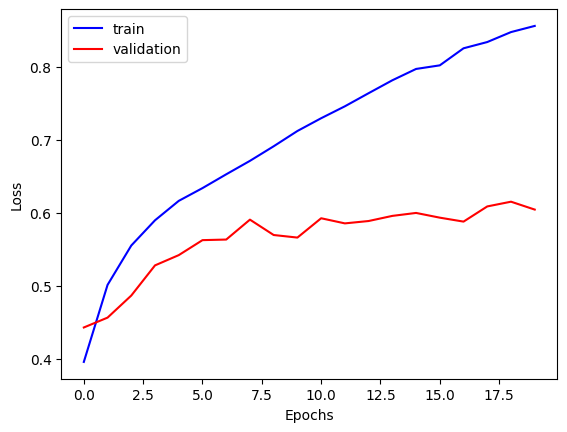

In [63]:
# Plotting the losses train/validation  
plt.plot(history.epoch, history.history["categorical_accuracy"],color="blue",label="train")
plt.plot(history.epoch, history.history["val_categorical_accuracy"],color="red",label="validation")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
 
plt.show()

# Next 20 Epochs

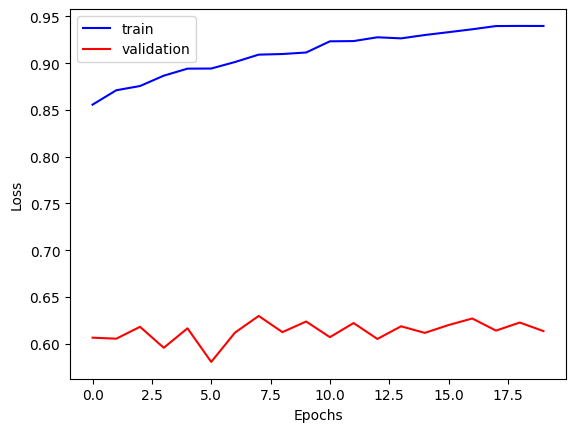

In [65]:
# Plotting the losses train/validation  
plt.plot(history.epoch, history.history["categorical_accuracy"],color="blue",label="train")
plt.plot(history.epoch, history.history["val_categorical_accuracy"],color="red",label="validation")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
 
plt.show()

actual : 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


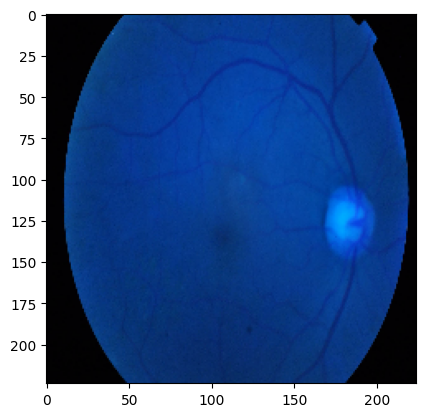

In [84]:
import cv2
mild_1 = "/mnt/c/Users/varaj/OneDrive/Documents/KARTHIK 2.0/Project/Deep Learning/Diabetic Retinopathy/Data/diabetic_retinopathy_sovirath_224x224_dataset/Mild/3ee17aa12e46.png"
mild_img_1 = cv2.imread(mild_1)
test_1 = np.expand_dims(mild_img_1,axis=0)
print("actual : 2")
np.argmax(model_cnn_1.predict([test_1]))
plt.imshow(mild_img_1)

actual : 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
predicted : 4


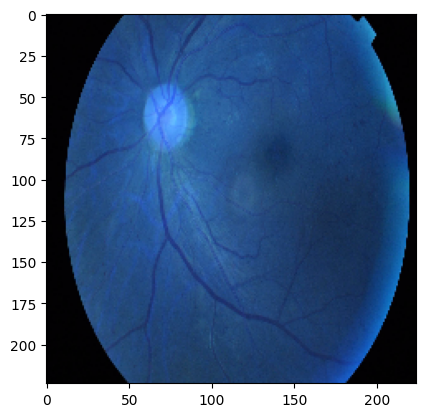

In [88]:
mild_1 = "/mnt/c/Users/varaj/OneDrive/Documents/KARTHIK 2.0/Project/Deep Learning/Diabetic Retinopathy/Data/diabetic_retinopathy_sovirath_224x224_dataset/Mild/bb11db08584a.png"
mild_img_1 = cv2.imread(mild_1)
test_1 = np.expand_dims(mild_img_1,axis=0)
print("actual : 2")
print("predicted :",np.argmax(model_cnn_1.predict([test_1])))
plt.imshow(mild_img_1)

actual : 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
predicted : 0


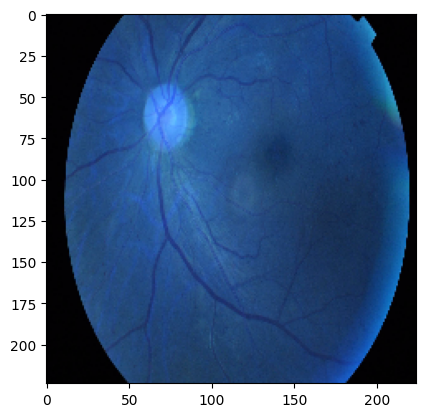

In [100]:
path = "/mnt/c/Users/varaj/OneDrive/Documents/KARTHIK 2.0/Project/Deep Learning/Diabetic Retinopathy/Data/diabetic_retinopathy_sovirath_224x224_dataset/No_DR/c096131ad065.png"
image = cv2.imread(path)
test = np.expand_dims(image,axis=0)
print("actual : 0")
print("predicted :",np.argmax(model_cnn_1.predict([test])))
plt.imshow(mild_img_1)

actual : 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
predicted : 0


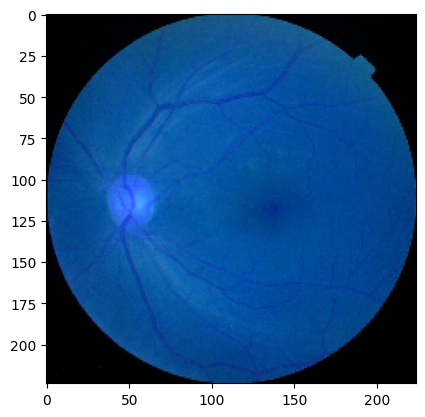

In [99]:
path = "/mnt/c/Users/varaj/OneDrive/Documents/KARTHIK 2.0/Project/Deep Learning/Diabetic Retinopathy/Data/diabetic_retinopathy_sovirath_224x224_dataset/No_DR/8344c783da65.png"
image = cv2.imread(path)
test = np.expand_dims(image,axis=0)
print("actual : 0")
print("predicted :",np.argmax(model_cnn_1.predict([test])))
plt.imshow(image)

actual : 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
predicted : 4


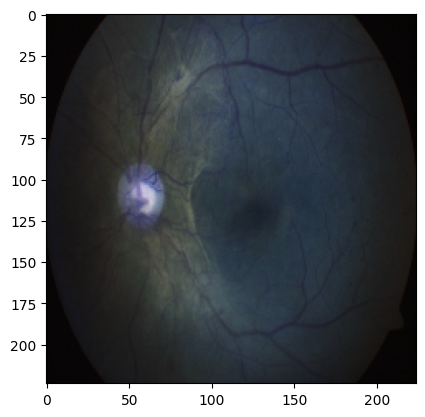

In [101]:
path = "/mnt/c/Users/varaj/OneDrive/Documents/KARTHIK 2.0/Project/Deep Learning/Diabetic Retinopathy/Data/diabetic_retinopathy_sovirath_224x224_dataset/Proliferate_DR/bfdee9be1f1d.png"
image = cv2.imread(path)
test = np.expand_dims(image,axis=0)
print("actual : 4")
print("predicted :",np.argmax(model_cnn_1.predict([test])))
plt.imshow(image)

In [102]:
model_cnn_1.save("../models/temp/cnn_1_impl_from_paper.keras")